# Adaptation of the ACT model for time series 

The original paper, Enriched CNN-Transformer Feature Aggregation Networks for Super-Resolution, proposes a hybrid model architecture combining Convolutional Neural Networks (CNN) and Transformers. This combination aims to leverage both local features (through CNNs) and global dependencies (through Transformers) to achieve high-quality image super-resolution.

The model consists of the following components:

<center>
    <img src="imgs/act.png" alt="ACT" style="width:1000px;"/>
      <figcaption>ACT model to enhance image resolution.</figcaption>
</center>

1. __Head Module__:
This module takes in the low-resolution input image and extracts shallow features. It comprises two residual convolution blocks, which provide an initial feature map of the input before deeper processing.

2. __Body Module (Main Processing)__: The core of the architecture includes two parallel branches: a CNN branch and a Transformer branch.
    - __CNN Branch__: This branch is made up of convolutional blocks, specifically leveraging a Residual Channel Attention Block (RCAB). These blocks specialize in capturing local, fine-grained features and ensuring consistent attention across channels.
    - __Transformer Branch__: The Transformer branch uses a multi-head self-attention mechanism but includes additional components:
        - __Cross-Scale Token Attention (CSTA)__: This module generates multi-scale tokens by tokenizing the input features differently, allowing the network to capture self-similar patterns across different scales.
        - The Transformer blocks in this branch consist of both multi-head self-attention (MHSA) and CSTA, which enables them to reason about patterns not just within the same scale but also across multiple scales, thus improving the resolution by leveraging more intricate details.
3. __Fusion Block__:
    - This component combines information from both branches. The features from the CNN and Transformer branches are aggregated using 1x1 convolutional layers and concatenated to form a unified representation.
    - This fusion of local and global features is then split and fed back into each branch to reinforce the CNN’s and Transformer’s features iteratively.

4. __Tail Module__:
    - In the final step, the fused features undergo an upsampling operation via PixelShuffle, which rearranges the channels into spatial dimensions to generate a high-resolution output.

5. __Positional Embeddings and Multi-Scale Tokens__:
    - Unlike typical Transformers for vision tasks, this model does not use positional embeddings as they do not significantly impact performance for super-resolution.
    - The CSTA module dynamically adjusts token sizes to achieve multi-scale attention, which is essential in improving super-resolution quality for images with repeating patterns.

In this notebook we will modify these components to allow the model to improve the resolution of 1D time series.

In [1]:
# Necessary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from skorch import NeuralNet
import numpy as np
import matplotlib.pyplot as plt
import random
import skorch.callbacks.training as training

## Head
The head module in the ACT class is the first stage of processing for the input signal in the super-resolution architecture. This stage transforms the low-resolution input $S_{LR}$ into a higher-dimensional intial shallow feature representation, setting it up for further enhancement by the CNN and Transformer components. It consists of the following components:

1. __Initial Convolution Layer:__ 
This layer applies a convolution with a kernel of size 3 to the input signal. It takes in *n_channels* channels (which in our case will be 1, since our time series are one dimensional) and outputs a feature map with *n_feats* channels. This operation establishes the baseline feature map.<br>

1. __Two Residual Blocks (ResBlock):__
These blocks each apply two convolutional layers with a kernel of size 5 to the output of the previous convolution. Inside each residual block, the input goes through an initial convlution, followed by a ReLU activation, and then a second convolution layer (batch normalization can be optionally included after the ReLU activation and second convolution). The output of these two layers is then added back to the input, creating a residual connection. This connection helps the network retain crucial information and improves gradient flow through the network.

<center>
    <img src="imgs/resblock.png" alt="ResBlock" style="width:500px;"/>
      <figcaption>ResBlock structure: Two Convolution layers with a ReLU activation in between, and final residual connection.</figcaption>
</center>

The author mentions that this is a common approach in enhancing image resolution, and lists these as references:
- [Pre-trained image processing transformer](https://arxiv.org/abs/2012.00364)
- [Enhanced deep residual networks for single image super-resolution](https://arxiv.org/abs/1707.02921)
- [Image super-resolution using very deep residual channel attention networks](https://arxiv.org/abs/1807.02758)
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385): This paper wasn't listed, but it was the one that originally introduced the idea of residual connections. 

The output the head module
  $$ F_0 = H_{Head}(S_{LR}) $$
gives us our first shallow feature representation of our low resolution signal.

__Note__: The head module only affects the channel dimension, so that we go from a tensor of dimension (batch, n_channels, length) to one of dimension (batch, n_features, length). This means that after each convolution the signal length will remain the same, which is done in such way to allow for residual connections. This logic will be mantained in the following modules as well.

### Implementation

In [2]:
# Default convolution function. This conv will be used in all future modules
# Notice that for the specified padding the original siginal length will always remain the same
# which is necessary for the universal residual connections present in the module to work
def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv1d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernel_size,
        padding=(kernel_size // 2),
        bias=bias,
    )

In [3]:
# Define the ResBlock class
class ResBlock(nn.Module):
    def __init__(
        self,
        conv,
        n_feats,
        kernel_size,
        bias=True,
        batch_norm=False,
        act=nn.ReLU(True),
        res_scale=1,
    ):
        super(ResBlock, self).__init__()
        self.res_scale = res_scale

        modules = []
        for i in range(2):
            modules.append(
                conv(
                    in_channels=n_feats,
                    out_channels=n_feats,
                    kernel_size=kernel_size,
                    bias=bias,
                )
            )
            if i == 0:  # Add an activation function after the first convolution
                modules.append(act)
            if batch_norm:
                modules.append(nn.BatchNorm1d(n_feats))

        self.body = nn.Sequential(*modules)

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x
        return res

### Example

In [4]:
# Simulate a batch of 10 one dimensional times series of 50 points
N = 10  # Number of time series (batch size)
L = 50  # Number of points in each times series (original resolution)

x = torch.randn(N, L)

# We need to add a channel dimension of 1 for our code to work
x = x.unsqueeze(1)
x.shape

torch.Size([10, 1, 50])

In [5]:
# Parameters for the head module
n_channels = 1  # Input channels
n_feats = 64  # Number of features that will be extracted

head = nn.Sequential(
    default_conv(n_channels, n_feats, 3), # First convolution to extract initial feature maps
    ResBlock(conv=default_conv, n_feats=n_feats, kernel_size=5, act=nn.ReLU(True)),
    ResBlock(conv=default_conv, n_feats=n_feats, kernel_size=5, act=nn.ReLU(True)),
)
x = head(x)
identitiy = x  # We will use this later for a final residual connection before the tail module
x.shape

torch.Size([10, 64, 50])

## Body
### Transformer branch

The Transformer branch in the body module is designed to capture global dependencies and multi-scale relationships within the input. It consists of:

1. __Embedding__: Each input feature map is broken down into tokens. Each token represents a small patch of the time series, and tokenization allows the model to attend to relationships across different parts of the time series. Then these tokens are embedded with a linear map and added to the original tokenization for an extra residual connection.
1. __Multi-Head Self-Attention (MHSA)__: This block captures self-similar patterns across the same scale.
1. __Cross-Scale Token Attention (CSTA)__: This module enhances the ability of the network to analyze patterns across different scales, combining information from both small and large token sizes. 
1. __Feed Forward Network (FFN)__: Linear transformations are applied to enhance the encoded features after attention mechanisms.
1. __Unembedding__: We return to the original shape before the embedding so that we have enriched feature maps, obtained through the attention mechanism.

__Note__: In this implementation we are not using the CSTA module, and instead of using a custom implementation of the transformer like the original paper we will be using the standard pytorch module.

#### Tokenization  
For tokenization, we will follow these steps:

1. Generate non-overlapping patches of size P along each channel and arrange them into a matrix. This transforms our dimension as follows: $(N, C, L) \rightarrow (N, C, P, L_p)$, where $N$ and $C$ are respectively the batch and channel dimension, $L$ is the original sequence length, $P$ the number of patches and $L_p$ the patch length. 
1. Swap the channel and patch number dimmensions: $(N, C, P, L_p) \rightarrow (N, P, C, L_p)$. This is equivalent to putting the corresponding patch of each feature map in the same matrix.
1. Flatten the resulting matrix to generate a single token representation of each patch: $(N, P, C, L_p) \rightarrow (N, P, C*L_p)$
1. Generate the embedding with a linear map and a residual connection. The dimension remains the same.

Steps 1 to 3  can be done witht a combinatiton of the `F.unfold` pytorch method and transposition operation.

In [6]:
class Embedding(nn.Module):
    def __init__(
        self,
        n_feats,
        token_size,
    ):
        super(Embedding, self).__init__()
        self.token_size = token_size
        embedding_dim = n_feats * token_size
        flatten_dim = embedding_dim

        self.linear_encoding = nn.Linear(flatten_dim, embedding_dim)

    def forward(self, x):
        # Add a dimension of 1 to height, since F.unfold only works on 4D data
        x = x.unsqueeze(2) # (N, C, L) -> (N, C, 1, L)
        x = F.unfold(x, kernel_size=(1, self.token_size), stride=(1, self.token_size)) # (N, C*L, P)
        x = x.transpose(1, 2) # (N, P, C*L)
        
        return self.linear_encoding(x) + x # Get the embedding and add the residual connection

#### Unembedding

In [7]:
class Unembedding(nn.Module):
    def __init__(self, token_size, seq_len):
        super(Unembedding, self).__init__()
        self.token_size = token_size
        self.seq_len = seq_len

    def forward(self, x):
        x = x.transpose(2, 1)
        x = F.fold(
            x,
            output_size=(1, self.seq_len),
            kernel_size=(1, self.token_size),
            stride=self.token_size,
        )
        return x.squeeze()
    
def unembedding(x, token_size, seq_len):
    x = x.transpose(2, 1)
    x = F.fold(
        x,
        output_size=(1, seq_len),
        kernel_size=(1, token_size),
        stride=token_size,
    )
    return x.squeeze()

#### Example

In [8]:
token_size = 3
d_model = n_feats * token_size  # Embedding dimension
n_heads = 8  # Number of attention heads
n_layers = 2  # Number of transformer layers
encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads)
seq_len = 50

transformer_branch = nn.Sequential(
    Embedding(n_feats=n_feats, token_size=token_size),
    nn.TransformerEncoder(
        encoder_layer=encoder_layer, num_layers=n_layers, norm=nn.LayerNorm(d_model)
    ),
    Unembedding(token_size=token_size, seq_len=seq_len),
)

x = transformer_branch(x)
x.shape

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([10, 64, 50])

### Convolution branch

The CNN branch in the body module is responsible for capturing local features from the input feature map, which is critical for tasks like super-resolution where fine-grained spatial details are essential. This branch is primarily implemented with Residual Groups (RG) and Residual Channel Attention Blocks (RCAB), which work together to capture and enhance the local spatial features across channels.

1. __Residual Groups (RG)__: Each group consists of multiple Residual Channel Attention Blocks (RCAB). Each RCAB block focuses on refining features within channels, while the Residual Group allows the network to maintain residual connections across a sequence of RCABs. The original idea comes from the paper [Image super-resolution using very deep residual channel attention networks](https://arxiv.org/abs/1807.02758), where it indicated that the "channel attention (CA) mechanism to adaptively rescale each  channel-wise feature by modeling the interdependencies across feature channels. Such CA mechanism allows our proposed network to concentrate on more useful channels and enhance discriminative learning ability."

2. __Final Convolutional Layer__: The last convolution layer reduces or maintains the number of channels and further consolidates the local features captured by the previous blocks.

#### Implementation

In [9]:
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        # nn.AdaptiveAvgPool1d automatically set the kernel and stride for the desired output size
        self.avg_pool = nn.AdaptiveAvgPool1d(output_size=1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
            nn.Conv1d(
                in_channels=channel,
                out_channels=channel // reduction,
                kernel_size=1,
                padding=0,
                bias=True,
            ),
            nn.ReLU(inplace=True),
            nn.Conv1d(
                in_channels=channel // reduction,
                out_channels=channel,
                kernel_size=1,
                padding=0,
                bias=True,
            ),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y


class RCAB(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, reduction):
        super(RCAB, self).__init__()
        modules_body = [
            conv(in_channels=n_feat, out_channels=n_feat, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
        ]
        modules_body.append(CALayer(channel=n_feat, reduction=reduction))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res


class ResidualGroup(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, reduction, n_resblocks):
        super(ResidualGroup, self).__init__()
        modules_body = [
            RCAB(conv=conv, n_feat=n_feat, kernel_size=kernel_size, reduction=reduction)
            for _ in range(n_resblocks)
        ]
        modules_body.append(conv(in_channels=n_feat, out_channels=n_feat, kernel_size=kernel_size))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

#### Example

In [10]:
reduction = 16
n_resblocks = 12
n_resgroups = 4

modules_cnn = [
    ResidualGroup(
        conv=default_conv,
        n_feat=n_feats,
        kernel_size=3,
        reduction=reduction,
        n_resblocks=n_resblocks,
    )
    for _ in range(n_resgroups)
]

modules_cnn.append(default_conv(n_feats, n_feats, 3))
cnn_branch = nn.Sequential(*modules_cnn)
cnn_branch(torch.randn(10, 64, 50)).shape

torch.Size([10, 64, 50])

### Fusion block

The fusion blocks are designed to combine the outputs of the Transformer branch and the CNN branch within the body module. These blocks play a crucial role in aggregating global and local features to create a unified representation that enhances the model's resolution capabilities.

The fusion blocks consist of:

1. __Integration of Transformer and CNN Features:__
    - Before fusion, the outputs of the Transformer branch and CNN branch  are concatenated along the channel dimension.
    - This combined tensor is passed through the fusion block, where multiple FB layers refine the features.

1. __Fusion Block (FB)__:
    - Each fusion block (FB) is essentially a sequence of convolution layers with a kernel size of 1x1.
    - These convolution layers mix feature maps along the channel dimension.
    - The repeated application of FB layers allows for progressive refinement of the merged features.

1. __Residual Connections__:
    - Each fusion block adds its output back to the concatenated input tensor, ensuring that the original information is preserved during the refinement process.

#### Implementation

In [11]:
class FB(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, bias=False, act=nn.ReLU(True)):
        super(FB, self).__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if i == 0:
                modules_body.append(act)
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

## Tail

We use this module to upscale the enriched features from the body module and reconstruct the final result. This process includes the PixelUnshuffle1D operation, which upscales feature maps by rearranging channel-wise features to the spatial dimension. Finally, we add a single convolution layer to predict the final improved resolution result.

### Implementation

In [12]:
# Taken from: https://github.com/serkansulun/pytorch-pixelshuffle1d/blob/master/pixelshuffle1d.py


class PixelShuffle1D(torch.nn.Module):
    """
    1D pixel shuffler. https://arxiv.org/pdf/1609.05158.pdf
    Upscales sample length, downscales channel length
    "short" is input, "long" is output
    """

    def __init__(self, upscale_factor):
        super(PixelShuffle1D, self).__init__()
        self.upscale_factor = upscale_factor

    def forward(self, x):
        batch_size = x.shape[0]
        short_channel_len = x.shape[1]
        short_width = x.shape[2]

        long_channel_len = short_channel_len // self.upscale_factor
        long_width = self.upscale_factor * short_width

        x = x.contiguous().view(
            [batch_size, self.upscale_factor, long_channel_len, short_width]
        )
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(batch_size, long_channel_len, long_width)

        return x

In [13]:
class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feats, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:  # Is scale = 2^n?
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feats, 2 * n_feats, 3, bias))
                m.append(PixelShuffle1D(2))
                if bn:
                    m.append(nn.BatchNorm1d(n_feats))
                if act == "relu":
                    m.append(nn.ReLU(True))
                elif act == "prelu":
                    m.append(nn.PReLU(n_feats))

        else:
            m.append(
                conv(
                    in_channels=n_feats,
                    out_channels=scale * n_feats,
                    kernel_size=scale,
                    bias=bias,
                )
            )
            m.append(PixelShuffle1D(scale))
            if bn:
                m.append(nn.BatchNorm1d(n_feats))
            if act == "relu":
                m.append(nn.ReLU(True))
            elif act == "prelu":
                m.append(nn.PReLU(n_feats))

        super(Upsampler, self).__init__(*m)

### Example

In [14]:
scale = 5
conv = default_conv

tail = nn.Sequential(
    Upsampler(conv, scale, n_feats, act=False),
    conv(in_channels=n_feats, out_channels=n_channels, kernel_size=3),
)

x = x + identitiy
x = tail(x).squeeze()
x.shape

torch.Size([10, 250])

## Final model: ACT time

In [15]:
# model_name = "50_250"
# num_low = 50
# num_high = 250
model_name = "1000_5000"
num_low = 1000
num_high = 5000

### Implementation

In [16]:
class ActTime(torch.nn.Module):
    def __init__(self, args):
        super(ActTime, self).__init__()

        conv = default_conv

        n_channels = args.n_channels
        self.n_feats = args.n_feats
        self.token_size = args.token_size
        n_heads = args.n_heads
        n_layers = args.n_layers
        scale = args.scale
        reduction = args.reduction
        n_resblocks = args.n_resblocks
        n_resgroups = args.n_resgroups
        self.n_fusionblocks = args.n_fusionblocks

        embedding_dim = self.n_feats * self.token_size
        hidden_dim = embedding_dim * args.expansion_ratio

        # Head definition
        self.head = nn.Sequential(
            default_conv(n_channels, self.n_feats, 3),
            ResBlock(conv=conv, n_feats=self.n_feats, kernel_size=5, act=nn.ReLU(True)),
            ResBlock(conv=conv, n_feats=self.n_feats, kernel_size=5, act=nn.ReLU(True)),
        )

        # Body definition
        # Transformer encoder and embedding layers
        self.embedding = Embedding(n_feats=self.n_feats, token_size=self.token_size)
        self.encoder_layers = nn.ModuleList(
            [
                nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=n_heads)
                for _ in range(n_layers // 2)
            ]
        )

        # Convolution layers with channel attetion
        modules_cnn = [
            ResidualGroup(
                conv=conv,
                n_feat=self.n_feats,
                kernel_size=3,
                reduction=reduction,
                n_resblocks=n_resblocks,
            )
            for _ in range(n_resgroups)
        ]

        modules_cnn.append(
            conv(in_channels=self.n_feats, out_channels=self.n_feats, kernel_size=3)
        )
        self.cnn_branch = nn.Sequential(*modules_cnn)

        # Fusion Blocks
        self.fusion_block = nn.ModuleList(
            [
                nn.Sequential(
                    FB(conv, self.n_feats * 2, 1, act=nn.ReLU(True)),
                    FB(conv, self.n_feats * 2, 1, act=nn.ReLU(True)),
                    FB(conv, self.n_feats * 2, 1, act=nn.ReLU(True)),
                    FB(conv, self.n_feats * 2, 1, act=nn.ReLU(True)),
                )
                for _ in range(self.n_fusionblocks)
            ]
        )

        # MLP stand for multilayer perceptron
        self.fusion_mlp = nn.ModuleList(
            [
                nn.Sequential(
                    nn.LayerNorm(embedding_dim),
                    nn.Linear(embedding_dim, hidden_dim),
                    nn.GELU(),
                    nn.Linear(hidden_dim, embedding_dim),
                )
                for _ in range(self.n_fusionblocks - 1)
            ]
        )

        self.fusion_cnn = nn.ModuleList(
            [
                nn.Sequential(
                    conv(in_channels=self.n_feats, out_channels=self.n_feats, kernel_size=3),
                    nn.ReLU(True),
                    conv(in_channels=self.n_feats, out_channels=self.n_feats, kernel_size=3),
                )
                for _ in range(self.n_fusionblocks - 1)
            ]
        )

        # Single convolution to lessen dimension after body module
        self.conv_last = conv(
            in_channels=self.n_feats*2, out_channels=self.n_feats, kernel_size=3
        )

        # Tail definition
        self.tail = nn.Sequential(
            Upsampler(conv=conv, scale=scale, n_feats=self.n_feats, act=False),
            conv(in_channels=self.n_feats, out_channels=n_channels, kernel_size=3),
        )

    def forward(self, x):
        seq_len = x.size(-1) # Save sequence length for later steps
        x = x.unsqueeze(1)  # Add channel dimmension of 1
        x = self.head(x)
        identitiy = x  # Save head result for residual connection before tail
        
        x_tkn = self.embedding(x) # Generate embeddings for transformer
        
        for i in range(self.n_fusionblocks):
            x_tkn = self.encoder_layers[i](x_tkn) # Transformer block result
            x = self.cnn_branch[i](x) # CNN block result

            x_tkn_res, x_res = x_tkn, x # Save output for residual connection after fusion
            x_tkn = unembedding(x_tkn, self.token_size, seq_len) # Token unembedding for fusion

            f = torch.cat((x, x_tkn), 1)
            f = f + self.fusion_block[i](f)

            if i != (self.n_fusionblocks - 1):
                x_tkn, x = torch.split(f, self.n_feats, 1)

                x_tkn = self.embedding(x_tkn)
                x_tkn = self.fusion_mlp[i](x_tkn)+ x_tkn_res

                x = self.fusion_cnn[i](x) + x_res
            break

        x = self.conv_last(f)
        x = x + identitiy  # Final residual connection
        x = tail(x).squeeze()  # Remove channel dimension
        
        return x

### Datasets

In [18]:
train_data_dir = f"datasets/train"

low_res_signals = torch.from_numpy(
    np.loadtxt(f"{train_data_dir}/low_res.txt", delimiter=" ", dtype=np.float32)
)
high_res_signals = torch.from_numpy(
    np.loadtxt(f"{train_data_dir}/high_res.txt", delimiter=" ", dtype=np.float32)
)

print(f"Low resolution dataset shape: {low_res_signals.shape}")
print(f"High resolution dataset shape: {high_res_signals.shape}")

Low resolution dataset shape: torch.Size([1000, 1000])
High resolution dataset shape: torch.Size([1000, 5000])


### Training using Skorch

In [19]:
class L2Loss(nn.Module):
    def __init__(self):
        super(L2Loss, self).__init__()

    def forward(self, input, target):
        mse = nn.MSELoss(reduction="none")
        return torch.sqrt(torch.sum(mse(input, target), dim=1)).mean()

In [20]:
class Args(object):
    def __init__(self, **entries):
        self.__dict__.update(entries)

params = {
    "n_channels": 1,
    "n_feats": 64,
    "token_size": 3,
    "n_heads": 8,
    "n_layers": 8,
    "scale": 5,
    "reduction": 16,
    "n_resblocks": 12,
    "n_resgroups": 4,
    "n_fusionblocks": 4,
    "expansion_ratio": 4
}

args = Args(**params)

In [ ]:
net = NeuralNet(
    module=ActTime,
    criterion=nn.MSELoss,
    max_epochs=150,
    batch_size=64,
    optimizer=torch.optim.Adam,
    lr=0.001,
    module__args=args,
    callbacks=[training.EarlyStopping(patience=30)],
    # verbose=0,
)

net.fit(low_res_signals, high_res_signals);

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        3.9610        0.9713  40.6252
      2        0.3731        0.3967  39.7142


### Results

In [144]:
# # We can excute this cell to load an already trained model
# net = NeuralNet(
#     module=ActTime,
#     criterion=nn.MSELoss,
#     module__args=args
# )

# net.initialize()
# net.load_params(f_params=f"saved_models/model_{model_name}.pkl")

In [145]:
test_data_dir = f"datasets/{model_name}/test"

test_low_res_signals = torch.from_numpy(
    np.loadtxt(f"{test_data_dir}/low_res.txt", delimiter=" ", dtype=np.float32)
)
test_high_res_signals = torch.from_numpy(
    np.loadtxt(f"{test_data_dir}/high_res.txt", delimiter=" ", dtype=np.float32)
)

print(f"Low resolution dataset shape: {test_low_res_signals.shape}")
print(f"High resolution dataset shape: {test_high_res_signals.shape}")

Low resolution dataset shape: torch.Size([300, 1000])
High resolution dataset shape: torch.Size([300, 5000])


In [146]:
def get_domains(start=0, end=4 * np.pi, num_low=50, num_high=250):
    return np.linspace(start, end, num_low), np.linspace(start, end, num_high)


def plot_signals(
    x_low,
    low_res_signals,
    x_high,
    high_res_signals,
    model_signals=None,
    sharex=True,
    sharey=False,
    rows=3,
    cols=1,
):

    f, axes = plt.subplots(rows, cols, sharex=sharex, sharey=sharey, figsize=(20, 10))

    for ax in axes.flat:
        index = random.randint(0, len(low_res_signals) - 1)
        y_true = high_res_signals[index]
        y_low = low_res_signals[index]

        ax.plot(x_high, y_true)
        ax.plot(x_low, y_low, "o")

        if model_signals is not None:
            y_pred = model_signals[index]
            ax.plot(x_high, y_pred)

    f.legend(
        ["True Signal", "Sub sample points", "Approximation"],
        loc="upper center",
        ncols=3,
    )
    plt.show()

In [147]:
x_low, x_high = get_domains(num_low=num_low, num_high=num_high)
model_signals = net.predict(test_low_res_signals)
# net.save_params(f_params=f"saved_models/model_{model_name}.pkl")

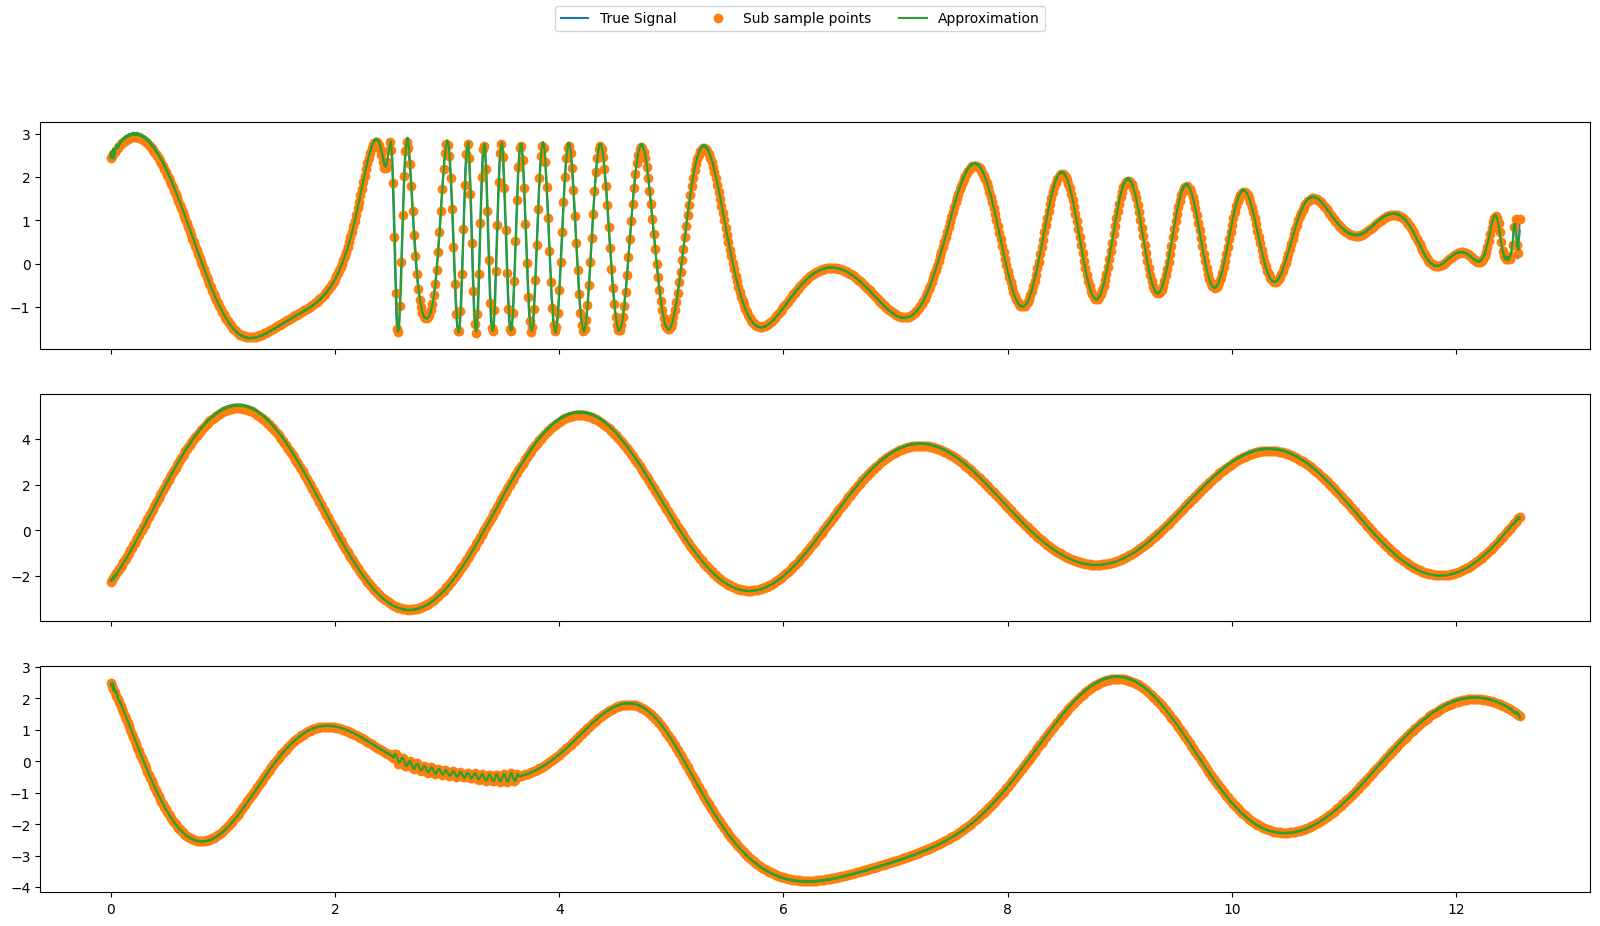

In [163]:
plot_signals(
    x_low,
    test_low_res_signals,
    x_high,
    test_high_res_signals,
    model_signals,
    sharey=False,
    rows=3,
    cols=1,
)